In [1]:
# --- TCN Bicikelj final training + test prediction with weather ---

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics.pairwise import haversine_distances
from tqdm import tqdm
import holidays
import random

# --- Hyperparameters ---
HISTORY_LEN = 48
PRED_HORIZON = 4
K_NEIGHBORS = 2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EMBED_DIM = 8
HIDDEN_DIM = 64
N_LAYERS = 4
LR = 0.0005
WEIGHT_DECAY = 0.0001
DROPOUT = 0.2
EPOCHS = 50
PATIENCE = 8
BATCH_SIZE = 128

# --- Load data ---
df = pd.read_csv("../data/bicikelj_train.csv")
meta = pd.read_csv("../data/bicikelj_metadata.csv")
station_cols = df.columns[1:]

# Clean and fill
for col in station_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df[station_cols] = df[station_cols].ffill().bfill()
df = df.dropna(subset=station_cols, how='all').reset_index(drop=True)

# --- Load weather ---
weather_df = pd.read_csv("../data/weather_ljubljana.csv", skiprows=2)
weather_df = weather_df.rename(columns={
    'temperature_2m (°C)': 'temperature_2m',
    'precipitation (mm)': 'precipitation',
    'windspeed_10m (km/h)': 'windspeed_10m',
    'cloudcover (%)': 'cloudcover'
})
weather_df['time'] = pd.to_datetime(weather_df['time'])
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize(None)
df_merged = pd.merge(df, weather_df, left_on='timestamp', right_on='time', how='left')

weather_features = ['temperature_2m', 'precipitation', 'windspeed_10m', 'cloudcover']
df_merged[weather_features] = df_merged[weather_features].ffill().bfill()

# --- Normalize ---
station_means = df_merged[station_cols].mean()
station_stds = df_merged[station_cols].std().replace(0, 1)
df_norm = df_merged.copy()
df_norm[station_cols] = (df_merged[station_cols] - station_means) / station_stds

weather_means = df_merged[weather_features].mean()
weather_stds = df_merged[weather_features].std().replace(0, 1)
df_norm[weather_features] = (df_merged[weather_features] - weather_means) / weather_stds

# --- Neighbors ---
coords = np.deg2rad(meta[['latitude', 'longitude']].values)
station_names = meta['name'].tolist()
dists = haversine_distances(coords, coords) * 6371
neighbors = {}
for i, name in enumerate(station_names):
    order = np.argsort(dists[i])
    nn_idx = [j for j in order if j != i][:K_NEIGHBORS]
    neighbors[name] = [station_names[j] for j in nn_idx]

# --- Dataset ---
class SharedTCNDataset(Dataset):
    def __init__(self, df, station_cols, neighbors, history_len, pred_horizon, weather_features):
        self.samples = []
        self.station_to_idx = {name: i for i, name in enumerate(station_cols)}
        timestamps = pd.to_datetime(df['timestamp'])

        hour_sin = np.sin(2 * np.pi * timestamps.dt.hour / 24)
        hour_cos = np.cos(2 * np.pi * timestamps.dt.hour / 24)
        dow_sin = np.sin(2 * np.pi * timestamps.dt.dayofweek / 7)
        dow_cos = np.cos(2 * np.pi * timestamps.dt.dayofweek / 7)
        month_sin = np.sin(2 * np.pi * timestamps.dt.month / 12)
        month_cos = np.sin(2 * np.pi * timestamps.dt.month / 12)
        is_weekend = (timestamps.dt.dayofweek >= 5).astype(float)
        slo_holidays = holidays.Slovenia()
        is_holiday = timestamps.dt.date.astype(str).isin([str(d) for d in slo_holidays]).astype(float)

        weather_array = df[weather_features].values

        time_feats = np.concatenate([
            np.stack([hour_sin, hour_cos, dow_sin, dow_cos,
                      month_sin, month_cos, is_weekend, is_holiday], axis=1),
            weather_array
        ], axis=1)

        bikes = df[station_cols].values.astype(np.float32)
        N = len(df)

        for s_name in station_cols:
            s_idx = self.station_to_idx[s_name]
            nn_idx = [self.station_to_idx[nn] for nn in neighbors[s_name]]
            series = bikes[:, [s_idx] + nn_idx]
            full_feats = np.concatenate([series, time_feats], axis=1)

            for i in range(history_len, N - pred_horizon + 1):
                x = full_feats[i - history_len:i]
                y = bikes[i:i + pred_horizon, s_idx]
                self.samples.append((x, y, s_idx))

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        x, y, sid = self.samples[idx]
        return (torch.tensor(x, dtype=torch.float32),
                torch.tensor(y, dtype=torch.float32),
                torch.tensor(sid, dtype=torch.long))

# --- TCN Block ---
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout):
        super().__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               padding=self.padding, dilation=dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               padding=self.padding, dilation=dilation)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None

    def forward(self, x):
        out = self.conv1(x)
        out = out[:, :, :-self.padding]
        out = self.relu(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = out[:, :, :-self.padding]
        out = self.relu(out)
        out = self.dropout(out)

        res = x if self.downsample is None else self.downsample(x)
        return out + res

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout, num_stations, embed_dim):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_ch = input_size if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            layers += [TemporalBlock(in_ch, out_ch, kernel_size, dilation_size, dropout)]
        self.tcn = nn.Sequential(*layers)
        self.embedding = nn.Embedding(num_stations, embed_dim)
        self.head = nn.Sequential(
            nn.Linear(num_channels[-1] + embed_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x, station_id):
        x = x.permute(0, 2, 1)
        tcn_out = self.tcn(x)[:, :, -1]
        emb = self.embedding(station_id)
        combined = torch.cat([tcn_out, emb], dim=1)
        return self.head(combined)
        

In [2]:
import numpy as np
import pandas as pd
import torch
import holidays
from sklearn.metrics.pairwise import haversine_distances

# --- Hyperparameters (should match those from your model!) ---
HISTORY_LEN = 48
PRED_HORIZON = 4
K_NEIGHBORS = 2

# --- Load metadata ---
meta = pd.read_csv("../data/bicikelj_metadata.csv")
station_cols = pd.read_csv("../data/bicikelj_train.csv").columns[1:]
station_names = meta['name'].tolist()

# --- Load weather (train, test) ---
weather_df = pd.read_csv("../data/weather_ljubljana.csv", skiprows=2)
weather_df = weather_df.rename(columns={
    'temperature_2m (°C)': 'temperature_2m',
    'precipitation (mm)': 'precipitation',
    'windspeed_10m (km/h)': 'windspeed_10m',
    'cloudcover (%)': 'cloudcover'
})
weather_df['time'] = pd.to_datetime(weather_df['time'])
weather_features = ['temperature_2m', 'precipitation', 'windspeed_10m', 'cloudcover']

weather_test_df = pd.read_csv("../data/weather_ljubljana_test.csv", skiprows=2)
weather_test_df = weather_test_df.rename(columns={
    'temperature_2m (°C)': 'temperature_2m',
    'precipitation (mm)': 'precipitation',
    'windspeed_10m (km/h)': 'windspeed_10m',
    'cloudcover (%)': 'cloudcover'
})
weather_test_df['time'] = pd.to_datetime(weather_test_df['time'])

# --- Load train for mean/std (needed for normalization) ---
df_train = pd.read_csv("../data/bicikelj_train.csv")
for col in station_cols:
    df_train[col] = pd.to_numeric(df_train[col], errors="coerce")
df_train[station_cols] = df_train[station_cols].ffill().bfill()
df_train = df_train.dropna(subset=station_cols, how='all').reset_index(drop=True)
df_train['timestamp'] = pd.to_datetime(df_train['timestamp']).dt.tz_localize(None)

df_train_merged = pd.merge(df_train, weather_df, left_on='timestamp', right_on='time', how='left')
df_train_merged[weather_features] = df_train_merged[weather_features].ffill().bfill()

station_means = df_train_merged[station_cols].mean()
station_stds = df_train_merged[station_cols].std().replace(0, 1)
weather_means = df_train_merged[weather_features].mean()
weather_stds = df_train_merged[weather_features].std().replace(0, 1)

# --- Load and prep test set ---
df_test = pd.read_csv("../data/bicikelj_test.csv")
for col in station_cols:
    df_test[col] = pd.to_numeric(df_test[col], errors="coerce")
df_test[station_cols] = df_test[station_cols].ffill().bfill()
df_test = df_test.dropna(subset=station_cols, how='all').reset_index(drop=True)
df_test['timestamp'] = pd.to_datetime(df_test['timestamp']).dt.tz_localize(None)

df_test_merged = pd.merge(df_test, weather_test_df, left_on='timestamp', right_on='time', how='left')
df_test_merged[weather_features] = df_test_merged[weather_features].ffill().bfill()

# --- Normalize test set using TRAIN stats ---
df_test_norm = df_test_merged.copy()
df_test_norm[station_cols] = (df_test_merged[station_cols] - station_means) / station_stds
df_test_norm[weather_features] = (df_test_merged[weather_features] - weather_means) / weather_stds

# --- Prepare neighbors dict (for input features) ---
coords = np.deg2rad(meta[['latitude', 'longitude']].values)
dists = haversine_distances(coords, coords) * 6371
neighbors = {}
for i, name in enumerate(station_names):
    order = np.argsort(dists[i])
    nn_idx = [j for j in order if j != i][:K_NEIGHBORS]
    neighbors[name] = [station_names[j] for j in nn_idx]

print("Test dataset and weather loaded, normalized, and ready.")


Test dataset and weather loaded, normalized, and ready.


In [3]:
model = TCN(
    input_size=(1 + K_NEIGHBORS + 8 + len(weather_features)),  # features per timestep
    output_size=PRED_HORIZON,
    num_channels=[HIDDEN_DIM] * N_LAYERS,
    kernel_size=3,
    dropout=DROPOUT,
    num_stations=len(station_cols),
    embed_dim=EMBED_DIM
)
model.load_state_dict(torch.load("tcn_model_final_weather.pt", map_location=DEVICE))
model.eval()
model.to(DEVICE)

TCN(
  (tcn): Sequential(
    (0): TemporalBlock(
      (conv1): Conv1d(15, 64, kernel_size=(3,), stride=(1,), padding=(2,))
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,))
      (relu): ReLU()
      (dropout): Dropout(p=0.2, inplace=False)
      (downsample): Conv1d(15, 64, kernel_size=(1,), stride=(1,))
    )
    (1): TemporalBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
      (relu): ReLU()
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (2): TemporalBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(4,))
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(4,))
      (relu): ReLU()
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (3): TemporalBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(16,), dila

In [ ]:
import numpy as np
import torch
import shap
import matplotlib.pyplot as plt

# --------- SETTINGS ---------
N_BACKGROUND_PER_STATION = 3  # Number of background samples per station for SHAP
PERCENT_PER_STATION = 0.001     # Percentage of test samples per station to use for SHAP explanation (e.g. 0.2 means 20%)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --------- PREPARE X_samples, SID_samples FROM TEST SET ---------
# (Assumes you loaded and normalized df_test_norm, have station_cols, weather_features, neighbors, etc.)

timestamps = pd.to_datetime(df_test_norm['timestamp'])
hour_sin = np.sin(2 * np.pi * timestamps.dt.hour / 24)
hour_cos = np.cos(2 * np.pi * timestamps.dt.hour / 24)
dow_sin = np.sin(2 * np.pi * timestamps.dt.dayofweek / 7)
dow_cos = np.cos(2 * np.pi * timestamps.dt.dayofweek / 7)
month_sin = np.sin(2 * np.pi * timestamps.dt.month / 12)
month_cos = np.cos(2 * np.pi * timestamps.dt.month / 12)
is_weekend = (timestamps.dt.dayofweek >= 5).astype(float)
slo_holidays = holidays.Slovenia()
is_holiday = timestamps.dt.date.astype(str).isin([str(d) for d in slo_holidays]).astype(float)

time_feats_arr = np.stack([hour_sin, hour_cos, dow_sin, dow_cos,
                           month_sin, month_cos, is_weekend, is_holiday], axis=1)
bikes = df_test_norm[station_cols].values.astype(np.float32)
weather_arr = df_test_norm[weather_features].values.astype(np.float32)

X_samples = []
SID_samples = []

N = len(df_test_norm)
station_to_idx = {name: i for i, name in enumerate(station_cols)}
for s_name in station_cols:
    s_idx = station_to_idx[s_name]
    nn_idx = [station_to_idx[nn] for nn in neighbors[s_name]]
    series = bikes[:, [s_idx] + nn_idx]
    full_feats = np.concatenate([series, time_feats_arr, weather_arr], axis=1)
    for i in range(HISTORY_LEN, N - PRED_HORIZON + 1):
        x_seq = full_feats[i - HISTORY_LEN:i]
        X_samples.append(x_seq)
        SID_samples.append(s_idx)

X_samples = torch.tensor(np.stack(X_samples), dtype=torch.float32)
SID_samples = torch.tensor(SID_samples, dtype=torch.long)

# --------- FEATURE NAMES ---------
n_neighbors = K_NEIGHBORS
feature_names_per_step = (
    ['station_value'] +
    [f'neighbor_{i+1}' for i in range(n_neighbors)] +
    ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'is_weekend', 'is_holiday'] +
    weather_features
)
NUM_STEP_FEATURES = len(feature_names_per_step)

flat_feature_names = []
for t in range(HISTORY_LEN):
    for fname in feature_names_per_step:
        flat_feature_names.append(f"{fname}_t-{HISTORY_LEN-t}")
flat_feature_names.append("station_id")

def flatten_sid(xs, sids):
    flat_xs = xs.reshape(xs.shape[0], -1)
    flat = np.concatenate([flat_xs, sids.reshape(-1, 1)], axis=1)
    return flat

# --------- STATION-BALANCED SAMPLING ---------
station_indices = {sid: [] for sid in range(len(station_cols))}
for i, sid in enumerate(SID_samples):
    station_indices[int(sid.item() if torch.is_tensor(sid) else sid)].append(i)

explain_idxs = []
background_idxs = []
for sid, idxs in station_indices.items():
    n = len(idxs)
    if n == 0:
        continue
    # Explanation: randomly sample PERCENT_PER_STATION for SHAP explanations
    n_explain = max(1, int(n * PERCENT_PER_STATION))
    chosen_explain = np.random.choice(idxs, size=n_explain, replace=False)
    explain_idxs.extend(chosen_explain)
    # Background: randomly sample N_BACKGROUND_PER_STATION for SHAP background
    chosen_background = np.random.choice(idxs, size=min(N_BACKGROUND_PER_STATION, n), replace=False)
    background_idxs.extend(chosen_background)

print("\nNumber of explanation samples per station:")
for sid, idxs in station_indices.items():
    n = len(idxs)
    n_explain = max(1, int(n * PERCENT_PER_STATION)) if n > 0 else 0
    print(f"  Station {sid:>2}: {n_explain} explanation samples from {n} total samples")
print(f"Total explanation samples: {len(explain_idxs)}")
print(f"Total background samples:   {len(background_idxs)}")


# --------- PREPARE EXPLAIN/BACKGROUND MATRICES ---------
explain_x = X_samples[explain_idxs].cpu().numpy()
explain_sid = SID_samples[explain_idxs].cpu().numpy()
full_explain = flatten_sid(explain_x, explain_sid)

background_x = X_samples[background_idxs].cpu().numpy()
background_sid = SID_samples[background_idxs].cpu().numpy()
full_background = flatten_sid(background_x, background_sid)

# --------- MODEL WRAPPER FOR SHAP ---------
def model_predict_flat(x):
    n_feat = NUM_STEP_FEATURES
    seq_len = HISTORY_LEN
    features = x[:, :seq_len * n_feat].reshape(-1, seq_len, n_feat)
    sids = x[:, -1].astype(np.int64)
    t = torch.tensor(features, dtype=torch.float32).to(DEVICE)
    sid = torch.tensor(sids, dtype=torch.long).to(DEVICE)
    with torch.no_grad():
        return model(t, sid).cpu().numpy()  # (batch, PRED_HORIZON)

# --------- SHAP EXPLAINER ---------
background_kmeans = shap.kmeans(full_background, 3)
explainer = shap.KernelExplainer(model_predict_flat, background_kmeans)

#explainer = shap.KernelExplainer(model_predict_flat, full_background)
shap_values = explainer.shap_values(full_explain)  # list: (N_EXPLAIN, N_FEATURES) for each output horizon
shap_array = np.stack(shap_values, axis=-1)        # (N_EXPLAIN, N_FEATURES, N_HORIZONS)

print(f"shap_array shape: {shap_array.shape}")

# --------- PLOT TOP 10 FEATURES (mean SHAP for horizon 0) ---------
mean_abs_shap = np.mean(np.abs(shap_array[:, :, 0]), axis=0)
top10_idx = np.argsort(mean_abs_shap)[-10:][::-1]
plt.figure(figsize=(10, 4))
plt.bar(range(10), mean_abs_shap[top10_idx])
plt.xticks(range(10), [flat_feature_names[i] for i in top10_idx], rotation=45, ha='right')
plt.title("Top 10 features by mean |SHAP| (horizon 0, station-balanced, test set)")
plt.tight_layout()
plt.show()



Number of explanation samples per station:
  Station  0: 15 explanation samples from 1509 total samples
  Station  1: 15 explanation samples from 1509 total samples
  Station  2: 15 explanation samples from 1509 total samples
  Station  3: 15 explanation samples from 1509 total samples
  Station  4: 15 explanation samples from 1509 total samples
  Station  5: 15 explanation samples from 1509 total samples
  Station  6: 15 explanation samples from 1509 total samples
  Station  7: 15 explanation samples from 1509 total samples
  Station  8: 15 explanation samples from 1509 total samples
  Station  9: 15 explanation samples from 1509 total samples
  Station 10: 15 explanation samples from 1509 total samples
  Station 11: 15 explanation samples from 1509 total samples
  Station 12: 15 explanation samples from 1509 total samples
  Station 13: 15 explanation samples from 1509 total samples
  Station 14: 15 explanation samples from 1509 total samples
  Station 15: 15 explanation samples from

  0%|          | 0/1260 [00:06<?, ?it/s]


KeyboardInterrupt: 

# Visualization

shap_array shape: (1260, 721, 4)
full_explain shape: (1260, 721)
flat_feature_names length: 721
Plotting SHAP summary (beeswarm) for horizon 0


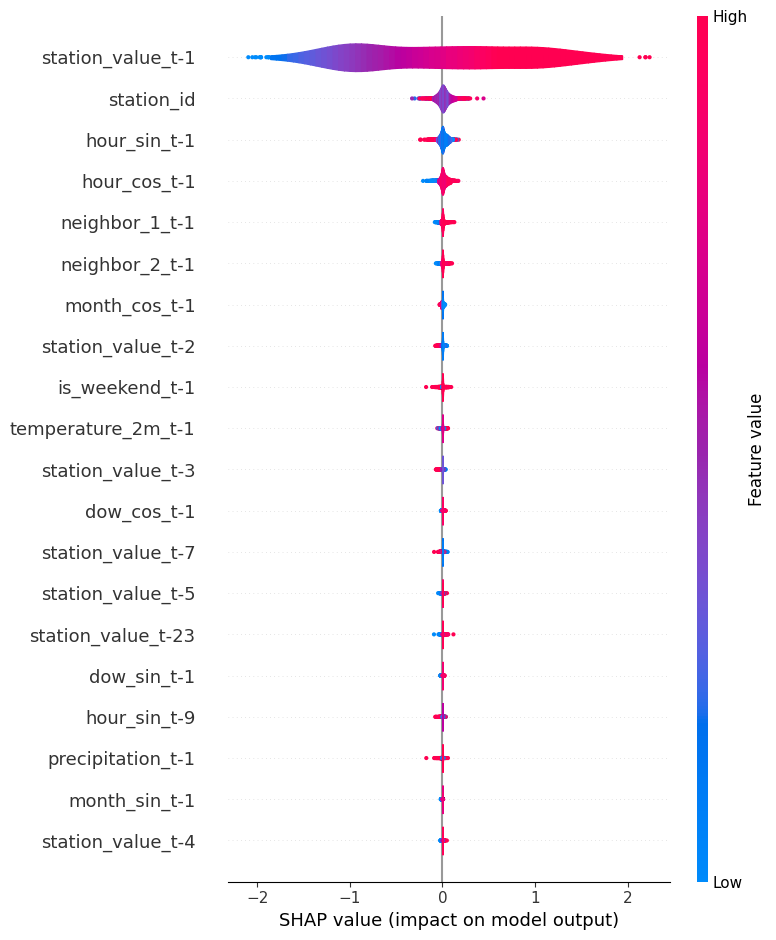

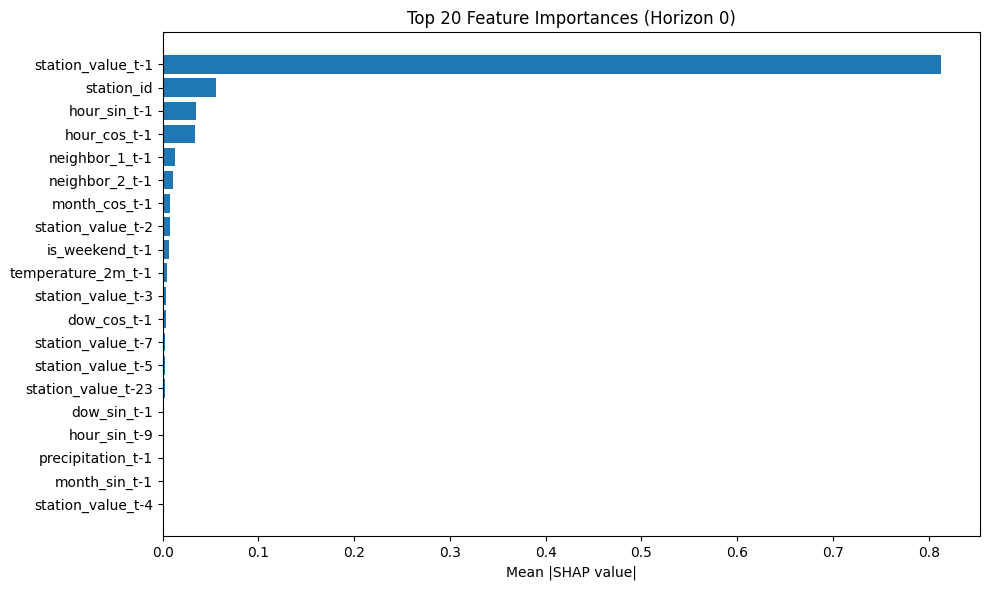

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import shap

# ---- LOAD ----
data = np.load('shap_output_testset.npz', allow_pickle=True)
shap_array = data['shap_array']           # (N_EXPLAIN, N_FEATURES, N_HORIZON)
full_explain = data['full_explain']       # (N_EXPLAIN, N_FLAT_FEATURES)
flat_feature_names = data['flat_feature_names']

print("shap_array shape:", shap_array.shape)
print("full_explain shape:", full_explain.shape)
print("flat_feature_names length:", len(flat_feature_names))

N_EXPLAIN, N_FEATURES, N_HORIZON = shap_array.shape

# ---- Choose which horizon to visualize ----
HORIZON = 0  # 0 for first step, 1 for second step, etc. (if you have multiple)
shap_vals = shap_array[:, :, HORIZON]     # (N_EXPLAIN, N_FEATURES)

# ---- SHAP summary plot (beeswarm) ----
print("Plotting SHAP summary (beeswarm) for horizon", HORIZON)
shap.summary_plot(
    shap_vals, 
    features=full_explain,
    feature_names=flat_feature_names,
    plot_type='violin',  # or 'dot'
    max_display=20
)

# ---- Mean absolute SHAP value (bar plot) ----
mean_abs_shap = np.abs(shap_vals).mean(axis=0)
sorted_idx = np.argsort(mean_abs_shap)[::-1]
plt.figure(figsize=(10, 6))
plt.barh([flat_feature_names[i] for i in sorted_idx[:20]][::-1], mean_abs_shap[sorted_idx[:20]][::-1])
plt.xlabel('Mean |SHAP value|')
plt.title(f'Top 20 Feature Importances (Horizon {HORIZON})')
plt.tight_layout()
plt.show()
